In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
# from dataprep.eda import create_report
import warnings
warnings.filterwarnings('ignore')


In [160]:
df = pd.read_csv('Boston_Housing.csv')

In [161]:
df = df.drop(df.columns[-1], axis=1)

There are 14 attributes in each case of the dataset. They are:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [163]:
# report = create_report(df)
# report.show_browser()


In [164]:
print(df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

ZN a 73.5% de valeurs égales à 0 (il s'agit d'une variable conditionnelle, pour les lot de plus de 25 000 sqft).   
CHAS a 93% de valeurs égales à 0, il s'agit d'une variable catégorielle.

In [165]:
np.shape(df)

(506, 14)

Le prix médian semble être plafonné à 50. On supprime donc les lignes où MEDV = 50

In [166]:
# df = df[~(df['MEDV'] >= 50.0)]
# print(np.shape(df))

<Axes: >

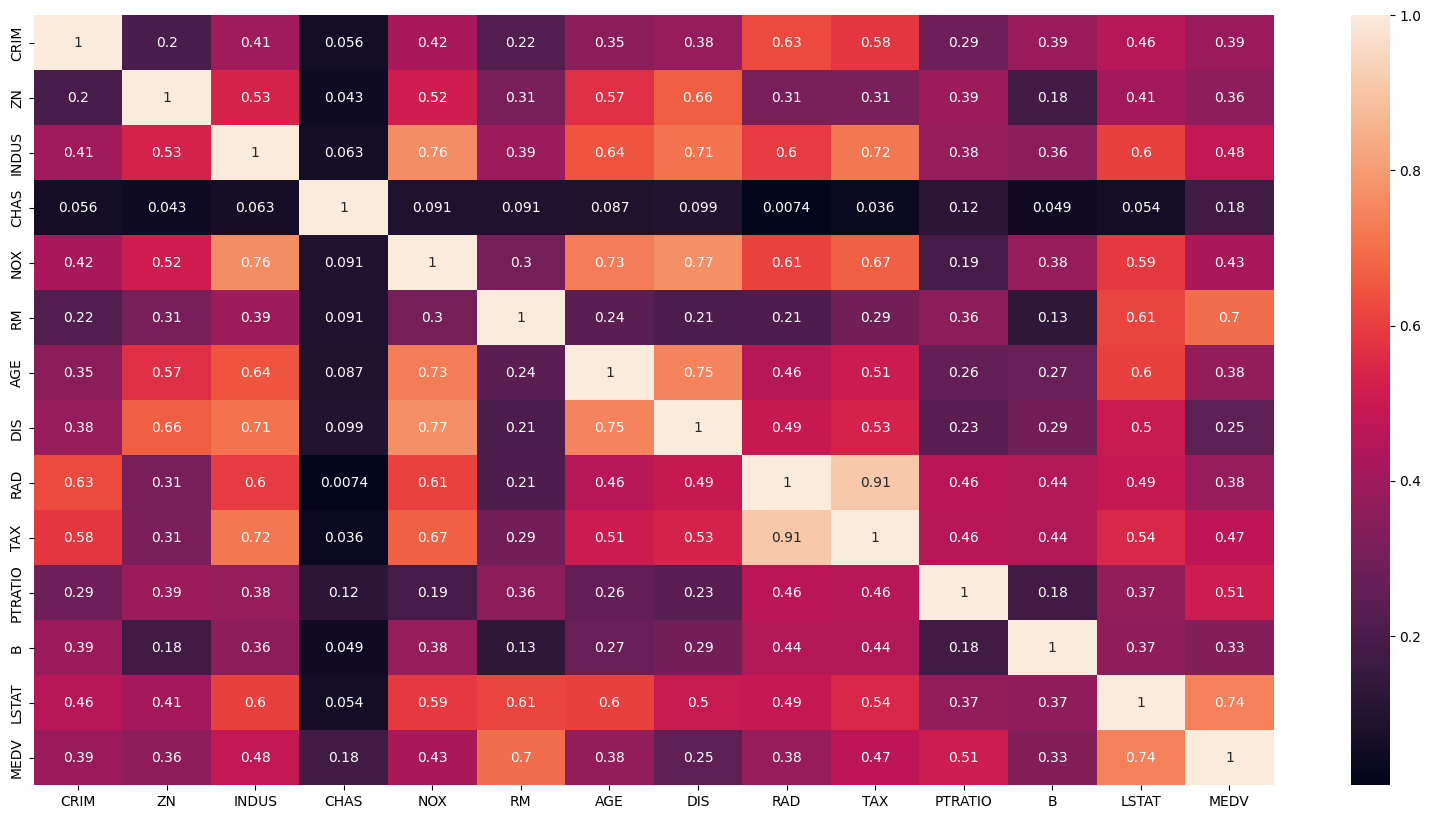

In [167]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

D'après la matrice de corrélation de Pearson (cf rapport) :
- TAX et RAD très corrélées l'une à l'autre (0.91)
- RM, LSAT, PTRATIO, INDUS, NOX, TAX très corrélées à MEDV (> 0.50)
- CRIM, ZN, AGE, RAD corrélation moyenne à MEDV ( entre 0.5 et 0.4)
- CHAS, DIS B très peu corrélés à MEDV (<0.4)

## Modélisation

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



### Choix du modèle (tests sur modèles naïf)

In [169]:
df_score=pd.DataFrame(columns = ["reg_lin", "lasso", "ridge", "decision_tree", "random_forest"])

#### Regression linéaire naifs : 

In [170]:
Xn=df.drop("MEDV", axis=1)
yn=df["MEDV"]
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=42)

modele_naif_reg_lin = linear_model.LinearRegression()
modele_naif_reg_lin.fit(Xn_train, yn_train )

modele_naif_lasso = linear_model.Lasso(alpha=1)
modele_naif_lasso.fit(Xn_train, yn_train )

modele_naif_ridge = linear_model.Ridge(alpha=1)
modele_naif_ridge.fit(Xn_train, yn_train )

# scoring sur X_test
df_score.loc[0, "reg_lin"] = modele_naif_reg_lin.score(Xn_test, yn_test)
df_score.loc[0, "lasso"] = modele_naif_lasso.score(Xn_test, yn_test)
df_score.loc[0, "ridge"] = modele_naif_ridge.score(Xn_test, yn_test)

print(df_score)


    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222           NaN           NaN


#### Decision Tree

In [171]:
decision_tree_naif = DecisionTreeRegressor(random_state=42)
decision_tree_naif.fit(Xn_train, yn_train )

df_score.loc[0, "decision_tree"] = decision_tree_naif.score(Xn_test, yn_test)
print(df_score)


    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222      0.857963           NaN


#### Random Forest 

In [172]:
random_forest_naif = RandomForestRegressor()
random_forest_naif.fit(Xn_train, yn_train )

df_score.loc[0, "random_forest"] = random_forest_naif.score(Xn_test, yn_test)
print(df_score)

    reg_lin     lasso     ridge decision_tree random_forest
0  0.668759  0.667145  0.666222      0.857963      0.886986


#### On choisi le modèle Random Forest

In [ ]:
numerical_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numerical_transformer, numerical_features),
    ], remainder="passthrough"
)

In [174]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
model = RandomForestRegressor()

In [176]:
pipe_rf = Pipeline([
     ('prep', preprocessor),
     ('model', model)
])

# Entrainement sur X_train
trained_model = pipe_rf.fit(X_train,y_train)

# scoring sur X_test
print(trained_model.score(X_test, y_test))

0.8940144555970795


## Pycaret

In [177]:
# from pycaret.regression import *
# s = setup(df, target = 'MEDV', preprocess=True)

Étape de prétraitement :  
  
**numerical_imputer** : Cette étape utilise SimpleImputer pour remplacer les valeurs manquantes dans les variables numériques sélectionnées (CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT).  

**categorical_imputer** : Cette étape utilise SimpleImputer avec la stratégie "most_frequent" pour remplacer les valeurs manquantes dans les variables catégorielles (aucune variable catégorielle n'a été sélectionnée).   

Il n'y a pas de valeurs manquantes, j'enlève donc l'étape de pretraitement auto

### Meilleur modèle

In [178]:
# best_model = compare_models()
# print(best_model)

In [179]:
# s = setup(df, target = 'MEDV', preprocess=False, session_id = 4546)
# models_to_compare = ['gbr', 'catboost', 'rf', 'et']
# best = compare_models(include=models_to_compare)

CatBoostRegressor, Extra Trees Regressor et Gradient Boosting Regressor sont les 3 meilleures modèles. 

## Gradient Boosting Regresor

In [180]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor()

In [181]:
pipe_gbr= Pipeline([
     ('prep', preprocessor),
     ('model', model_gbr)
])

# Entrainement sur X_train
trained_model_gbr = pipe_gbr.fit(X_train,y_train)

# scoring sur X_test
print(trained_model_gbr.score(X_test, y_test))

0.9162265227938803


## Feature Importance

In [182]:
# Récupération de l'importance des caractéristiques
feature_importance = model_gbr.feature_importances_

# Affichage des résultats
for feature_name, importance in zip(X.columns, feature_importance):
    print(f"{feature_name}: {importance}")


CRIM: 0.022939677949202826
ZN: 0.0005948317730715049
INDUS: 0.004391793169004792
CHAS: 0.03041114268070567
NOX: 0.41543817645676917
RM: 0.015372224940092466
AGE: 0.07488243697669955
DIS: 0.015748887624787395
RAD: 0.03153376883252769
TAX: 0.012203251777949205
PTRATIO: 0.37429043938732287
B: 0.0001641387792112926
LSTAT: 0.002029229652655645


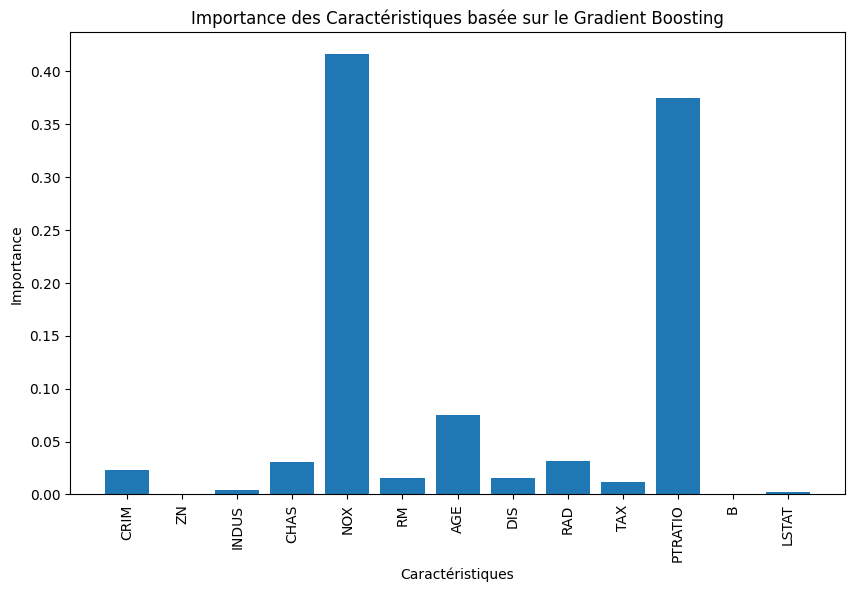

In [183]:
# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des Caractéristiques basée sur le Gradient Boosting')
plt.show()

En croisant ces info, on décide de supprimer les features : 
- ZN (car conditionnelle au lot de plus de 25000 sqft)
- B

In [184]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [195]:
X = df.drop(['MEDV', 'ZN', 'B'], axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
numerical_features2 = ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'RAD']
numerical_transformer = StandardScaler()

preprocessor2 = ColumnTransformer(
    transformers=[
        
        ('num', numerical_transformer, numerical_features2),
    ], remainder="passthrough"
)

In [197]:
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr)
])

# Entrainement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train,y_train)

# scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))

0.9160189208835559


Hyperparamètres par défaut :  
- n_estimators : 100
- learning_rate : 0.1
- max_depth : 3
- min_samples_split : 2
- min_samples_leaf : 1
- max_features : None

## Recherche des meilleurs hyperparamètres (Optuna)

In [188]:
from sklearn.metrics import mean_squared_error
import optuna

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    subsample = trial.suggest_float('subsample', 0.1, 1.0)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        subsample=subsample
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    return r2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Meilleurs hyperparamètres:", study.best_params)
print("RMSE avec les meilleurs hyperparamètres:", study.best_value)

[I 2023-06-12 15:41:45,692] A new study created in memory with name: no-name-a43df83c-5634-4321-9ade-f8deac19fe85
[I 2023-06-12 15:41:46,286] Trial 0 finished with value: 0.896196682732888 and parameters: {'learning_rate': 0.04352485371938046, 'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'subsample': 0.7351203124661112}. Best is trial 0 with value: 0.896196682732888.
[I 2023-06-12 15:41:46,985] Trial 1 finished with value: 0.8498845010178124 and parameters: {'learning_rate': 0.020779381689527796, 'n_estimators': 800, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': None, 'subsample': 0.26589251367533484}. Best is trial 0 with value: 0.896196682732888.
[I 2023-06-12 15:41:47,236] Trial 2 finished with value: 0.8913603195541101 and parameters: {'learning_rate': 0.04070986307283041, 'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'sub

KeyboardInterrupt: 

Meilleurs hyperparamètres: {'n_estimators': 579, 'learning_rate': 0.0731645148741222, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'auto'}

## Entrainement du modèle avec les meilleurs hyperparamètres défini avec Optuna

In [ ]:
# Création du nouveau modèle avec les meilleurs hyperparamètres
best_params = study.best_params
model_gbr_best = GradientBoostingRegressor(**best_params)

# Création du pipeline avec le nouveau modèle et le préprocesseur
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr_best)
])

# Entraînement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train, y_train)

# Scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))


0.9276304742184354


## Courbe d'apprentissage

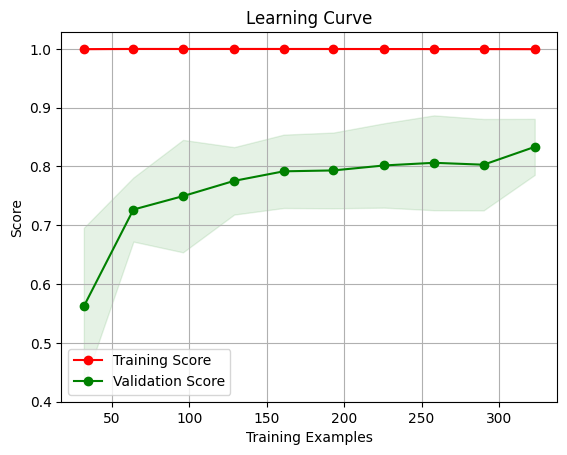

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
    
    plt.legend(loc="best")
    plt.show()

# Utilisation de la fonction pour tracer les courbes d'apprentissage
plot_learning_curve(trained_model_gbr2, X_train, y_train)


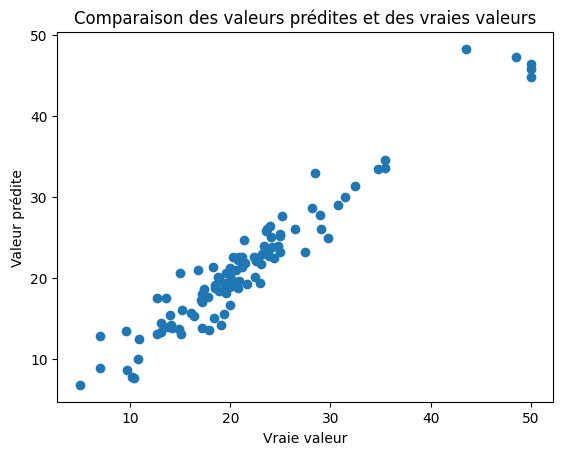

In [ ]:
import matplotlib.pyplot as plt

# Obtenir les valeurs prédites du modèle
y_pred = trained_model_gbr2.predict(X_test)

# Tracer le graphique
plt.scatter(y_test, y_pred)
plt.xlabel('Vraie valeur')
plt.ylabel('Valeur prédite')
plt.title('Comparaison des valeurs prédites et des vraies valeurs')
plt.show()
